## Dependencies and Configuration

In [34]:
import json
from xml.etree import ElementTree

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import metapy

In [2]:
DATASET_DIR = '/srv/data/rchiu7/510lab/clef_meta/clef2018collection_B/'
METAPY_CONFIG = '/srv/data/rchiu7/510lab/clef_meta/config.toml'
CLEF_CORPUS_FILE = '/srv/data/rchiu7/510lab/clef_meta/clef2018collection_B/clef2018-full-corpus.txt'
QUERIES_FILE = '/srv/data/rchiu7/510lab/clef_meta/clef2020_queries.txt'
RELEVANCE_FILE = '/srv/data/rchiu7/510lab/clef_meta/relevance.txt'
CLEAN_RELEVANCE_FILE = '/srv/data/rchiu7/510lab/clef_meta/relevance_processed.txt'

## Ranking and Evaluation

#### Doc Mapping and Relevance Judgements

In [4]:
# create mapping from documents to their id
doc_idx = {}
with open(CLEF_CORPUS_FILE, 'r') as f:
    for doc_id, line in enumerate(f):
        split_line = line.strip().split(' ')
        doc_idx[split_line[-1]] = doc_id

In [5]:
# store relevance judgements for lookup
relevance_judgements = {}
with open(RELEVANCE_FILE, 'r') as f:
    for line in f:
        split_line = line.strip().split(' ')
        doc_id = -1
        if split_line[2] in doc_idx.keys():
            if split_line[0] in relevance_judgements:
                relevance_judgements[split_line[0]].append(split_line[2])
            else:
                relevance_judgements[split_line[0]] = [split_line[2]]

print(relevance_judgements, len(relevance_judgements['151001']))

{'151001': ['3aad40f4-0b91-4f16-8c29-3a12abcb2f7e', '47603005-1e61-424c-9219-73a271d416f0', '398b5d05-202b-4475-b2d3-1030d8cd753b', '2806afa9-20e0-42d3-88f9-7b1708c88827', '462bb4d4-3d22-436f-ae06-4f9bfcad1aa1', 'ec9efd34-440c-4a59-b55f-3bce1500cf1b', 'df22fde9-4ed4-4509-a423-5e74293b1e58', '9819fac0-59bb-493d-b9eb-e62a406f6b21', 'aefaf781-6658-451f-a423-06aa9b6f348e', '74b55156-91fa-469c-89d9-1f91e628ca6c', '5af3a0c3-937b-43b2-97d8-b3841a037339', 'ac8c66f6-a859-4f09-b34a-3d98c2bc8f6a', '15cd7cc9-c46f-4941-8a31-957185a4c76c', 'c5276eb4-ddd4-4b60-b05c-27bad3cd1cf0', '86a5951a-1fc2-4923-82a3-9aa237b47fae'], '152001': ['acf129d6-6bb0-4ef2-a4f7-7ce2ba575a56', '1724504d-8b21-41bb-8bc3-dc7a509b3d6c', '9df15153-954e-49b1-b91e-523dfa80f24d', '0ffc1b00-a0db-4e47-b553-848a92c9d8a8', '635caba7-c900-4a35-8ba3-74b24168c3cc', '92e320df-eaec-4f4c-9aaa-d8cc7948aecb', '0a522e17-f361-4a6d-a292-b7f3514b5677', '164debbf-08b8-44c6-87f3-085704c1af66'], '153001': ['17fb9098-115c-4794-9626-3391393d590d', 'b27

In [4]:
# remake relevance judgement file to allow for evaluation
relevance_lines = []
with open(RELEVANCE_FILE, 'r') as f:
    for line in f:
        split_line = line.strip().split(' ')
        doc_id = -1
        if split_line[2] in doc_idx.keys():
            doc_id = doc_idx[split_line[2]]
        relevance_lines.append((split_line[0], doc_id, split_line[-1]))

with open(CLEAN_RELEVANCE_FILE, 'w') as f:
    for i, line in enumerate(relevance_lines):
        if i == len(relevance_lines) - 1:
            f.write(line[0] + ' ' + str(line[1]) + ' ' + line[2])
        else:
            f.write(line[0] + ' ' + str(line[1]) + ' ' + line[2] + '\n')
    

#### Compile queries

In [6]:
queries = {}
with open(QUERIES_FILE, 'r') as queries_file:
    qtree = ElementTree.parse(queries_file)
    qroot = qtree.getroot()
    for child in qroot:
        queries[child[0].text.strip()] = child[1].text.strip()

print(queries)

{'151001': 'anemia diet therapy', '152001': 'emotional and mental disorders', '153001': 'american diabetes association', '154001': 'high blood pressure', '155001': 'infectious disease prevention', '156001': 'food allergy test', '157001': 'orlistat drug profile', '158001': 'radiation health effect', '159001': 'smoking and heart disease', '160001': 'smoking cessation products', '161001': 'omega 3 fatty acids', '162001': 'common medication errors', '163001': 'Anxiety coping skills', '164001': 'health benefits of spirulina', '165001': 'do allergies cause migraines', '166001': 'ketamine and its potential for abuse', '167001': 'head and neck cancer', '168001': 'hiv vaccine phase', '169001': 'normal lab values', '170001': 'rheumatoid arthritis prognosis', '171001': 'breast reduction and lift', '172001': 'involuntary trembling or quivering', '173001': 'drug food interaction', '174001': 'breakfast better student', '175001': 'Voltaren Emugel 1%', '176001': 'pelvic inflammatory disease', '177001'

#### Indexing and Ranking

In [13]:
def evaluate_recall(ranker_docs, q_id):
    num_correct = 0
    for (d_id, _) in ranker_docs:
        for file_name in relevance_judgements[q_id]:
            with open(DATASET_DIR + file_name) as f:
                file_text = f.read()
                if idx.metadata(d_id).get('content') == file_text:
                    num_correct += 1
                    break
    return num_correct, len(relevance_judgements[q_id])

In [8]:
def evaluate_overall_recall(temp_ranker):
    overall_correct = 0
    overall_relevant = 0
    for q_id, q in queries.items():
        query = metapy.index.Document()
        query.content(q)

        top_docs = temp_ranker.score(idx, query, num_results=20)
        correct, relevant = evaluate_recall(top_docs, q_id)
        overall_correct += correct
        overall_relevant += relevant
    return overall_correct / overall_relevant

In [9]:
idx = metapy.index.make_inverted_index(METAPY_CONFIG)

In [10]:
print(
    idx.avg_doc_length(),
    idx.num_docs(),
    idx.total_corpus_terms(),
    idx.unique_terms(),
    idx.term_text(1034026)
)

1125.699462890625 180634 203339598 1034030 ﬂuids


In [8]:
ranker = metapy.index.OkapiBM25()
# ev = metapy.index.IREval(METAPY_CONFIG)

In [22]:
overall_correct = 0
overall_relevant = 0
for q_id, q in queries.items():
    query = metapy.index.Document()
    query.content(q)

    top_docs = ranker.score(idx, query, num_results=20)
    correct, relevant = evaluate_recall(top_docs, q_id)
    overall_correct += correct
    overall_relevant += relevant
    print('Query {} # correct: {}'.format(q_id, correct / relevant))
print('OVERALL RECALL: {}'.format(overall_correct / overall_relevant))

Query 151001 # correct: 0.6
Query 152001 # correct: 0.25
Query 153001 # correct: 0.0
Query 154001 # correct: 0.125
Query 155001 # correct: 0.0
Query 156001 # correct: 0.006944444444444444
Query 157001 # correct: 0.875
Query 158001 # correct: 0.2
Query 159001 # correct: 0.09090909090909091
Query 160001 # correct: 0.5
Query 161001 # correct: 0.75
Query 162001 # correct: 0.2413793103448276
Query 163001 # correct: 0.0
Query 164001 # correct: 0.23529411764705882
Query 165001 # correct: 0.07142857142857142
Query 166001 # correct: 0.5517241379310345
Query 167001 # correct: 0.1111111111111111
Query 168001 # correct: 0.17592592592592593
Query 169001 # correct: 0.1111111111111111
Query 170001 # correct: 0.25
Query 171001 # correct: 0.0
Query 172001 # correct: 0.3333333333333333
Query 173001 # correct: 0.22580645161290322
Query 174001 # correct: 1.0
Query 175001 # correct: 0.5
Query 176001 # correct: 0.1724137931034483
Query 177001 # correct: 0.5
Query 178001 # correct: 0.031446540880503145
Query

#### Empirical Optimization

In [11]:
# k1 - document term smoothing
# b - length norm

k1_data = []
b_data = []

k1_range = np.arange(0, 3, 0.2)
b_range = np.arange(0, 1, 0.1)

In [16]:
# k1 plot
for k1 in k1_range:
    ranker_eval = metapy.index.OkapiBM25(k1, 0.75, 500)
    k1_data.append(evaluate_overall_recall(ranker_eval))
    
# b plot
for b in b_range:
    ranker_eval = metapy.index.OkapiBM25(1.2, b, 500)
    b_data.append(evaluate_overall_recall(ranker_eval))

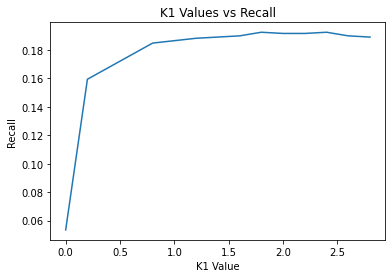

In [24]:
plt.plot(k1_range, k1_data)
plt.title('K1 Values vs Recall')
plt.xlabel('K1 Value')
plt.ylabel('Recall')
plt.show()

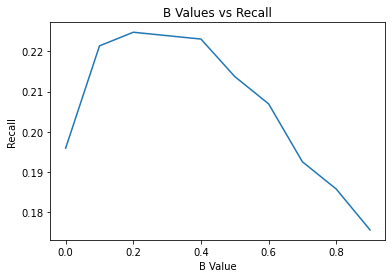

In [25]:
plt.plot(b_range, b_data)
plt.title('B Values vs Recall')
plt.xlabel('B Value')
plt.ylabel('Recall')
plt.show()

In [33]:
print(k1_range[np.argmax(k1_data)], b_range[np.argmax(b_data)])

1.8 0.2


In [28]:
tranker = metapy.index.OkapiBM25(2, 0.2)

In [29]:
overall_correct = 0
overall_relevant = 0
for q_id, q in queries.items():
    query = metapy.index.Document()
    query.content(q)

    top_docs = tranker.score(idx, query, num_results=20)
    correct, relevant = evaluate_recall(top_docs, q_id)
    overall_correct += correct
    overall_relevant += relevant
    print('Query {} # correct: {}'.format(q_id, correct / relevant))
print('OVERALL RECALL: {}'.format(overall_correct / overall_relevant))

Query 151001 # correct: 0.7333333333333333
Query 152001 # correct: 0.25
Query 153001 # correct: 0.0
Query 154001 # correct: 0.5
Query 155001 # correct: 0.25
Query 156001 # correct: 0.034722222222222224
Query 157001 # correct: 1.0
Query 158001 # correct: 0.2
Query 159001 # correct: 0.09090909090909091
Query 160001 # correct: 0.6875
Query 161001 # correct: 0.75
Query 162001 # correct: 0.29310344827586204
Query 163001 # correct: 0.0
Query 164001 # correct: 0.23529411764705882
Query 165001 # correct: 0.17857142857142858
Query 166001 # correct: 0.6206896551724138
Query 167001 # correct: 0.3333333333333333
Query 168001 # correct: 0.1574074074074074
Query 169001 # correct: 0.2222222222222222
Query 170001 # correct: 0.5
Query 171001 # correct: 0.0
Query 172001 # correct: 0.4444444444444444
Query 173001 # correct: 0.16129032258064516
Query 174001 # correct: 1.0
Query 175001 # correct: 0.5
Query 176001 # correct: 0.4827586206896552
Query 177001 # correct: 0.5
Query 178001 # correct: 0.1006289308

In [30]:
k1_b_data = []
for k1 in k1_range:
    for b in b_range:
        ranker_eval = metapy.index.OkapiBM25(k1, b, )
        k1_b_data.append(evaluate_overall_recall(ranker_eval))

In [45]:
triples = []
for i in range(len(k1_range)):
    for j in range(len(b_range)):
        triples.append([k1_range[i], b_range[j], k1_b_data[i * len(b_range) + j]])

np_triples = np.array(triples)

Text(0.5, 0, 'Recall')

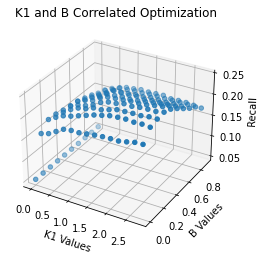

In [55]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(np_triples[:, 0], np_triples[:, 1], np_triples[:, 2])
ax.set_title('K1 and B Correlated Optimization')
ax.set_xlabel('K1 Values')
ax.set_ylabel('B Values')
ax.set_zlabel('Recall')

In [56]:
np.argmax(k1_b_data)

143

In [59]:
np_triples[143, :]

array([2.8       , 0.3       , 0.24173028])